In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import lzma
import re
from math import ceil

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 1000
#plt.style.use('ggplot')
plt.style.use('seaborn-paper')
mpl.rcParams['axes.linewidth'] = 0.7

In [2]:
def get_path(path):
    return re.search("(/[^/]+){2}$", path)[0][1:]

In [3]:
file = "results.json.xz"

data = None
if file.endswith('.xz'): file = lzma.open(file, 'rt')
data = pd.read_json(file)
data = data.sort_values(['file', 'mode'])

short_paths = data['file'].map( get_path )
data.update( short_paths )

In [4]:
succeeded = data[data.status == 'ok'][['file', 'mode', 'time_viper', 'time_viper_testing', 'inductions', 'induction_depth', 'candidates', 'added_axioms']]

In [5]:
len(succeeded)

563

In [6]:
states = set(data.status.values)
status_colors = {}
for s in states:
    if s == 'ok':
        c = 'green'
    elif s == 'cutintro_uncompressible':
        c = 'yellow'
    elif s == 'cutintro_termset_trivial':
        c = 'gold'
    elif 'timeout' in s:
        c = plt.cm.Blues(hash(s)/2**65+0.5)
    elif s.endswith('exception'):
        c = plt.cm.Reds(hash(s)/2**65+0.5)
    else:
        c = plt.cm.Greys(hash(s)/2**65+0.5)
    status_colors[s] = c

def plot_status(d, legend=True, **kwargs):
    plt.axis('equal')
    d.plot(kind='pie', autopct='%1.1f%%',
                        colors=[status_colors[s] for s in d.index], **kwargs) \
        .set_ylabel('')
    if legend: plt.legend(d.index, loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
data_by_mode = data.groupby('mode')
modes = set( data['mode'].values )

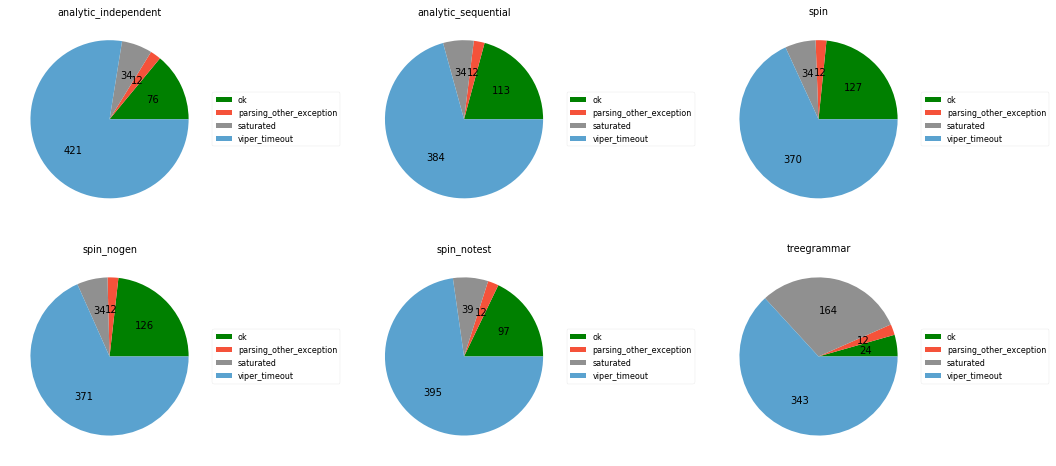

In [8]:
cols = int(ceil(len(modes) / 2))
fig, ax = plt.subplots(nrows = 2, ncols = cols, figsize = (18, 8))

for (i, mode) in enumerate( sorted( modes ) ):
    data_mode = data[data['mode'] == mode]
    p = ax[int(i / cols)][int(i % cols)]
    d = data_mode.groupby('status').size()
    total = sum(d)
    p.pie(d, autopct=lambda p: '{:.0f}'.format(p * total / 100), colors=[status_colors[s] for s in d.index])
    p.legend(d.index, loc='center left', bbox_to_anchor=(1, 0.5))
    p.set_title( mode )

In [9]:
succeeded.groupby('mode').size()

mode
analytic_independent     76
analytic_sequential     113
spin                    127
spin_nogen              126
spin_notest              97
treegrammar              24
dtype: int64

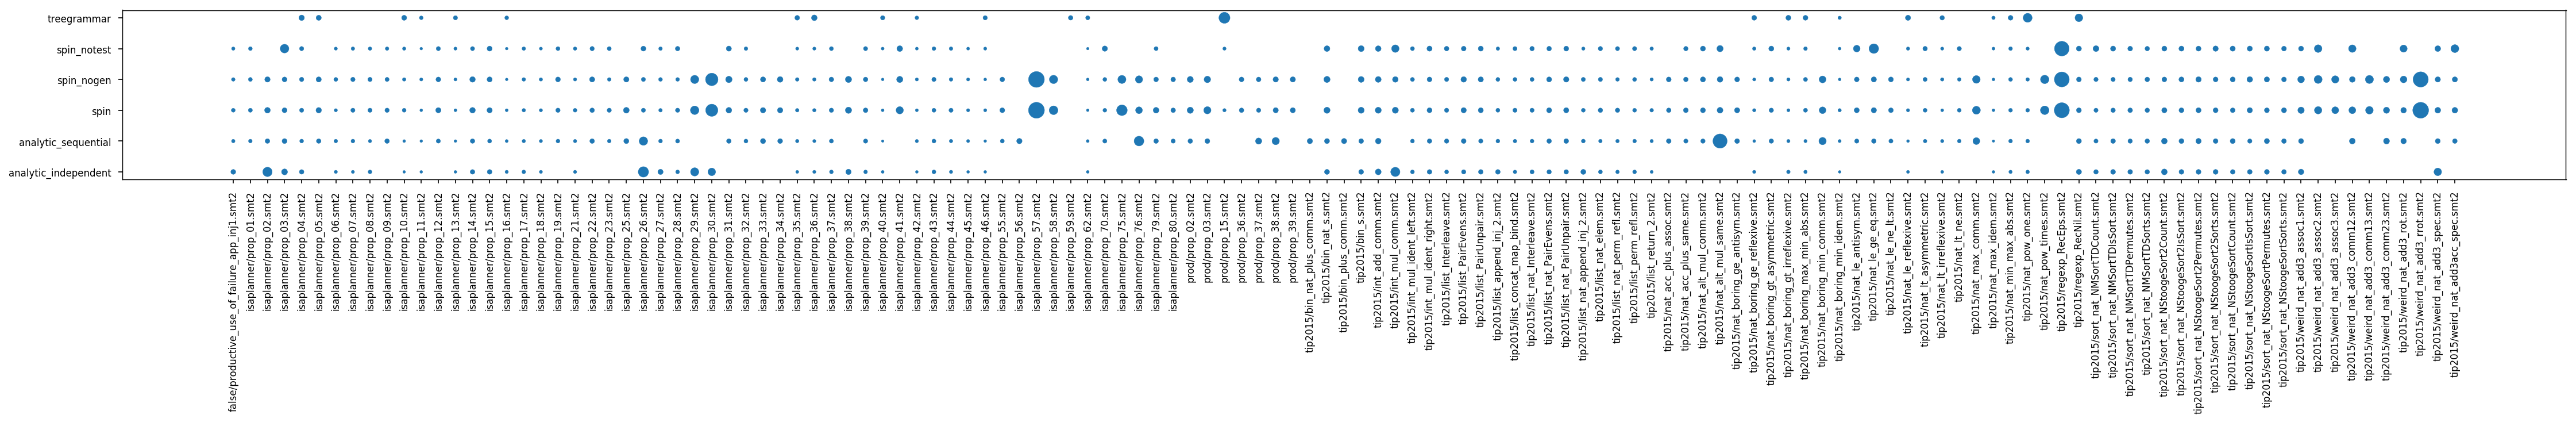

In [10]:
plt.figure( figsize=(30, 5), dpi=150 )
plt.xticks(rotation=90)
plt.scatter( succeeded['file'], succeeded['mode'], s=succeeded['time_viper'] / 300 )
plt.tight_layout()
# plt.savefig( "scatter.png" )

In [11]:
spin_success = succeeded[succeeded['mode'] == 'spin']
spin_files = set(spin_success.T.loc['file'])

Not solved by Spin:

In [12]:
for mode in sorted( modes ):
    succ = succeeded[succeeded['mode'] == mode]
    files = set(succ.T.loc['file'])
    diff = files - spin_files
    print( mode + ": " + str( diff ) )

analytic_independent: set()
analytic_sequential: {'tip2015/bin_nat_plus_comm.smt2', 'tip2015/bin_plus_comm.smt2', 'isaplanner/prop_56.smt2'}
spin: set()
spin_nogen: set()
spin_notest: set()
treegrammar: {'isaplanner/prop_59.smt2'}


Solved by Spin, but not the other:

In [13]:
for mode in sorted( modes ):
    succ = succeeded[succeeded['mode'] == mode]
    files = set(succ.T.loc['file'])
    diff = spin_files - files
    print( mode + ": " )
    for file in sorted( diff ):
        print( "\t" + file )
    print()

analytic_independent: 
	isaplanner/prop_01.smt2
	isaplanner/prop_05.smt2
	isaplanner/prop_09.smt2
	isaplanner/prop_12.smt2
	isaplanner/prop_19.smt2
	isaplanner/prop_22.smt2
	isaplanner/prop_23.smt2
	isaplanner/prop_25.smt2
	isaplanner/prop_31.smt2
	isaplanner/prop_32.smt2
	isaplanner/prop_33.smt2
	isaplanner/prop_34.smt2
	isaplanner/prop_41.smt2
	isaplanner/prop_55.smt2
	isaplanner/prop_57.smt2
	isaplanner/prop_58.smt2
	isaplanner/prop_70.smt2
	isaplanner/prop_75.smt2
	isaplanner/prop_76.smt2
	isaplanner/prop_79.smt2
	isaplanner/prop_80.smt2
	prod/prop_02.smt2
	prod/prop_03.smt2
	prod/prop_15.smt2
	prod/prop_36.smt2
	prod/prop_37.smt2
	prod/prop_38.smt2
	prod/prop_39.smt2
	tip2015/nat_acc_plus_assoc.smt2
	tip2015/nat_acc_plus_same.smt2
	tip2015/nat_alt_mul_comm.smt2
	tip2015/nat_alt_mul_same.smt2
	tip2015/nat_boring_ge_antisym.smt2
	tip2015/nat_boring_gt_asymmetric.smt2
	tip2015/nat_boring_min_comm.smt2
	tip2015/nat_le_antisym.smt2
	tip2015/nat_le_ge_eq.smt2
	tip2015/nat_le_ne_lt.smt2


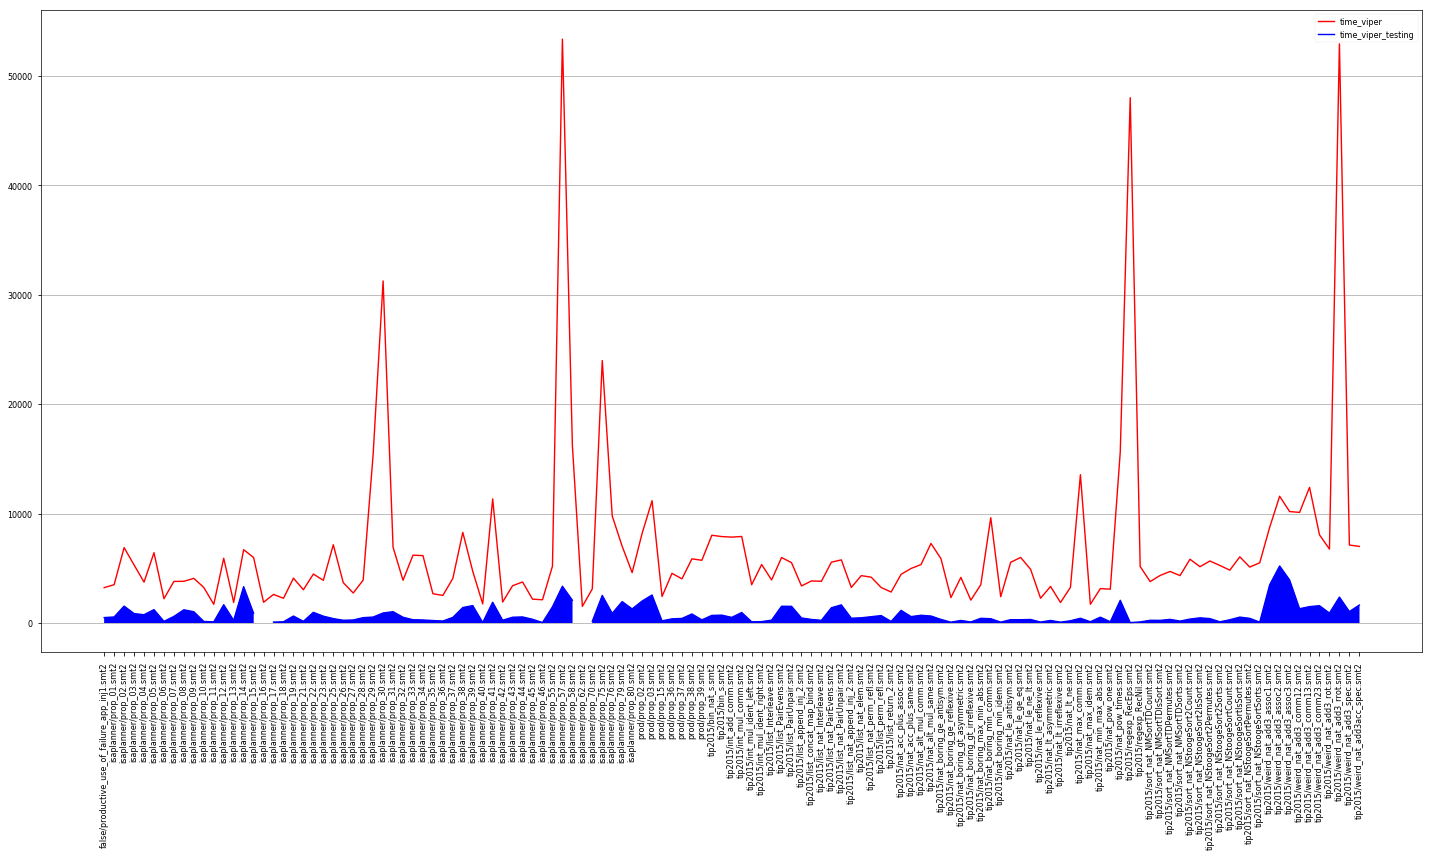

In [14]:
plt.figure( figsize=(20, 12) )
plt.grid( axis='y' )
plt.plot( spin_success['file'], spin_success['time_viper'], color='r' )
plt.plot( spin_success['file'], spin_success['time_viper_testing'], color='b' )
plt.fill_between( spin_success['file'], spin_success['time_viper_testing'], color='b' )
plt.legend()
plt.xticks( rotation = 90 )
plt.tight_layout()

In [15]:
pivot = succeeded.pivot_table( index=['file'], columns=['mode'] )
pivot

added_axioms             \
mode                                                  spin spin_nogen   
file                                                                    
false/productive_use_of_failure_app_inj1.smt2          0.0        0.0   
isaplanner/prop_01.smt2                                2.0        2.0   
isaplanner/prop_02.smt2                                5.0        5.0   
isaplanner/prop_03.smt2                                6.0        6.0   
isaplanner/prop_04.smt2                                4.0        4.0   
isaplanner/prop_05.smt2                                9.0        9.0   
isaplanner/prop_06.smt2                                0.0        0.0   
isaplanner/prop_07.smt2                                2.0        2.0   
isaplanner/prop_08.smt2                                2.0        2.0   
isaplanner/prop_09.smt2                                2.0        2.0   
isaplanner/prop_10.smt2                                0.0        0.0   
isaplanner/prop_11.smt2                                0.0        0.0   
isaplanner/prop_12.smt2                                4.0        4.0   
isaplanner/prop_13.smt2                                0.0        0.0   
isaplanner/prop_14.smt2                                2.0        2.0   
isaplanner/prop_15.smt2                                6.0        6.0   
isaplanner/prop_16.smt2                                0.0        0.0   
isaplanner/prop_17.smt2                                0.0        0.0   
isaplanner/prop_18.smt2                                1.0        1.0   
isaplanner/prop_19.smt2                                2.0        2.0   
isaplanner/prop_21.smt2                                1.0        1.0   
isaplanner/prop_22.smt2                                2.0        2.0   
isaplanner/prop_23.smt2                                2.0        2.0   
isaplanner/prop_25.smt2                                8.0        8.0   
isaplanner/prop_26.smt2                                0.0        0.0   
isaplanner/prop_27.smt2                                0.0        0.0   
isaplanner/prop_28.smt2                                5.0        5.0   
isaplanner/prop_29.smt2                                5.0        5.0   
isaplanner/prop_30.smt2                                5.0        5.0   
isaplanner/prop_31.smt2                                3.0        3.0   
isaplanner/prop_32.smt2                                1.0        1.0   
isaplanner/prop_33.smt2                                3.0        3.0   
isaplanner/prop_34.smt2                                0.0        0.0   
isaplanner/prop_35.smt2                                1.0        1.0   
isaplanner/prop_36.smt2                                1.0        1.0   
isaplanner/prop_37.smt2                                4.0        4.0   
isaplanner/prop_38.smt2                               15.0       15.0   
isaplanner/prop_39.smt2                                3.0        4.0   
isaplanner/prop_40.smt2                                0.0        0.0   
isaplanner/prop_41.smt2                               11.0       11.0   
isaplanner/prop_42.smt2                                0.0        0.0   
isaplanner/prop_43.smt2                                1.0        1.0   
isaplanner/prop_44.smt2                                1.0        1.0   
isaplanner/prop_45.smt2                                0.0        0.0   
isaplanner/prop_46.smt2                                0.0        0.0   
isaplanner/prop_55.smt2                                2.0        2.0   
isaplanner/prop_56.smt2                                NaN        NaN   
isaplanner/prop_57.smt2                               56.0       56.0   
isaplanner/prop_58.smt2                               33.0       33.0   
isaplanner/prop_59.smt2                                NaN        NaN   
isaplanner/prop_62.smt2                                0.0        0.0   
isaplanner/prop_70.smt2                                0.0        0.0   
isaplanner/prop_75.smt2        

In [16]:
succeeded.pivot_table( index=['file'], columns=['mode'] ).sum()

                    mode                
added_axioms        spin                       599.0
                    spin_nogen                 589.0
                    spin_notest                983.0
candidates          spin                      8666.0
                    spin_nogen                8302.0
                    spin_notest               8842.0
induction_depth     analytic_independent        44.0
                    analytic_sequential         79.0
                    spin                        96.0
                    spin_nogen                  95.0
                    spin_notest                 66.0
                    treegrammar                 13.0
inductions          analytic_independent        57.0
                    analytic_sequential        161.0
                    spin                       265.0
                    spin_nogen                 258.0
                    spin_notest                126.0
                    treegrammar                 13.0
time_

In [17]:
renamed = pivot.rename( index = str, columns = { 'analytic_sequential': 'as', 'analytic_independent': 'ai', 'treegrammar': 'tg' })
renamed

added_axioms             \
mode                                                  spin spin_nogen   
file                                                                    
false/productive_use_of_failure_app_inj1.smt2          0.0        0.0   
isaplanner/prop_01.smt2                                2.0        2.0   
isaplanner/prop_02.smt2                                5.0        5.0   
isaplanner/prop_03.smt2                                6.0        6.0   
isaplanner/prop_04.smt2                                4.0        4.0   
isaplanner/prop_05.smt2                                9.0        9.0   
isaplanner/prop_06.smt2                                0.0        0.0   
isaplanner/prop_07.smt2                                2.0        2.0   
isaplanner/prop_08.smt2                                2.0        2.0   
isaplanner/prop_09.smt2                                2.0        2.0   
isaplanner/prop_10.smt2                                0.0        0.0   
isaplanner/prop_11.smt2                                0.0        0.0   
isaplanner/prop_12.smt2                                4.0        4.0   
isaplanner/prop_13.smt2                                0.0        0.0   
isaplanner/prop_14.smt2                                2.0        2.0   
isaplanner/prop_15.smt2                                6.0        6.0   
isaplanner/prop_16.smt2                                0.0        0.0   
isaplanner/prop_17.smt2                                0.0        0.0   
isaplanner/prop_18.smt2                                1.0        1.0   
isaplanner/prop_19.smt2                                2.0        2.0   
isaplanner/prop_21.smt2                                1.0        1.0   
isaplanner/prop_22.smt2                                2.0        2.0   
isaplanner/prop_23.smt2                                2.0        2.0   
isaplanner/prop_25.smt2                                8.0        8.0   
isaplanner/prop_26.smt2                                0.0        0.0   
isaplanner/prop_27.smt2                                0.0        0.0   
isaplanner/prop_28.smt2                                5.0        5.0   
isaplanner/prop_29.smt2                                5.0        5.0   
isaplanner/prop_30.smt2                                5.0        5.0   
isaplanner/prop_31.smt2                                3.0        3.0   
isaplanner/prop_32.smt2                                1.0        1.0   
isaplanner/prop_33.smt2                                3.0        3.0   
isaplanner/prop_34.smt2                                0.0        0.0   
isaplanner/prop_35.smt2                                1.0        1.0   
isaplanner/prop_36.smt2                                1.0        1.0   
isaplanner/prop_37.smt2                                4.0        4.0   
isaplanner/prop_38.smt2                               15.0       15.0   
isaplanner/prop_39.smt2                                3.0        4.0   
isaplanner/prop_40.smt2                                0.0        0.0   
isaplanner/prop_41.smt2                               11.0       11.0   
isaplanner/prop_42.smt2                                0.0        0.0   
isaplanner/prop_43.smt2                                1.0        1.0   
isaplanner/prop_44.smt2                                1.0        1.0   
isaplanner/prop_45.smt2                                0.0        0.0   
isaplanner/prop_46.smt2                                0.0        0.0   
isaplanner/prop_55.smt2                                2.0        2.0   
isaplanner/prop_56.smt2                                NaN        NaN   
isaplanner/prop_57.smt2                               56.0       56.0   
isaplanner/prop_58.smt2                               33.0       33.0   
isaplanner/prop_59.smt2                                NaN        NaN   
isaplanner/prop_62.smt2                                0.0        0.0   
isaplanner/prop_70.smt2                                0.0        0.0   
isaplanner/prop_75.smt2        

In [18]:
print( renamed.to_html() )

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="3" halign="left">added_axioms</th>
      <th colspan="3" halign="left">candidates</th>
      <th colspan="6" halign="left">induction_depth</th>
      <th colspan="6" halign="left">inductions</th>
      <th colspan="6" halign="left">time_viper</th>
      <th colspan="2" halign="left">time_viper_testing</th>
    </tr>
    <tr>
      <th>mode</th>
      <th>spin</th>
      <th>spin_nogen</th>
      <th>spin_notest</th>
      <th>spin</th>
      <th>spin_nogen</th>
      <th>spin_notest</th>
      <th>ai</th>
      <th>as</th>
      <th>spin</th>
      <th>spin_nogen</th>
      <th>spin_notest</th>
      <th>tg</th>
      <th>ai</th>
      <th>as</th>
      <th>spin</th>
      <th>spin_nogen</th>
      <th>spin_notest</th>
      <th>tg</th>
      <th>ai</th>
      <th>as</th>
      <th>spin</th>
      <th>spin_nogen</th>
      <th>spin_notest</th>
      <th>tg</th>
      <th>spin</th>
      <th>spin_

In [19]:
for file in sorted( spin_files ):
    print( file )

false/productive_use_of_failure_app_inj1.smt2
isaplanner/prop_01.smt2
isaplanner/prop_02.smt2
isaplanner/prop_03.smt2
isaplanner/prop_04.smt2
isaplanner/prop_05.smt2
isaplanner/prop_06.smt2
isaplanner/prop_07.smt2
isaplanner/prop_08.smt2
isaplanner/prop_09.smt2
isaplanner/prop_10.smt2
isaplanner/prop_11.smt2
isaplanner/prop_12.smt2
isaplanner/prop_13.smt2
isaplanner/prop_14.smt2
isaplanner/prop_15.smt2
isaplanner/prop_16.smt2
isaplanner/prop_17.smt2
isaplanner/prop_18.smt2
isaplanner/prop_19.smt2
isaplanner/prop_21.smt2
isaplanner/prop_22.smt2
isaplanner/prop_23.smt2
isaplanner/prop_25.smt2
isaplanner/prop_26.smt2
isaplanner/prop_27.smt2
isaplanner/prop_28.smt2
isaplanner/prop_29.smt2
isaplanner/prop_30.smt2
isaplanner/prop_31.smt2
isaplanner/prop_32.smt2
isaplanner/prop_33.smt2
isaplanner/prop_34.smt2
isaplanner/prop_35.smt2
isaplanner/prop_36.smt2
isaplanner/prop_37.smt2
isaplanner/prop_38.smt2
isaplanner/prop_39.smt2
isaplanner/prop_40.smt2
isaplanner/prop_41.smt2
isaplanner/prop_42